# Figure: Output to the oviIN prominence 
1. Connect to neuprint and imports
2. Pull simple connections of the oviINr
3. Filter dataframe for each celltype to find where the oviIN type ranks with each celltype's outputs
4. Plot counts  

This file was written by Rhessa Weber Langstaff based on the hub_spoke_sandbox.ipynb file in the Gutierrez lab github.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuprint import Client
import matplotlib.patheffects as path_effects
import matplotlib as mpl
import bokeh
import bokeh.palettes

from neuprint import fetch_simple_connections, fetch_synapse_connections, NeuronCriteria as NC


auth_token_file = open("flybrain.auth.txt", 'r')
auth_token = next(auth_token_file).strip()
try:
    np_client = Client('neuprint.janelia.org', dataset='hemibrain:' + 'v1.2.1', token=auth_token)
except:
    np_client = None



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Body Ids of oviINs
oviINr= 423101189
oviINl= 485934965

In [5]:
# inputs to the oviINr
ovi_inputs = fetch_simple_connections(None, oviINr)
ovi_inputs

,bodyId_pre,bodyId_post,weight,type_pre,type_post,instance_pre,instance_post,conn_roiInfo
0,611015907,423101189,287,SMP176,oviIN,SMP176_R,oviIN_R,"{'INP': {'pre': 54, 'post': 53}, 'CRE(R)': {'p..."
1,5813087891,423101189,255,SMP544,oviIN,SMP544_R,oviIN_R,"{'LX(R)': {'pre': 66, 'post': 65}, 'LAL(R)': {..."
2,1598011458,423101189,243,LAL134,oviIN,LAL134_R,oviIN_R,"{'LX(R)': {'pre': 42, 'post': 42}, 'LAL(R)': {..."
3,5813022375,423101189,236,IB017,oviIN,IB017_R,oviIN_R,"{'SNP(R)': {'pre': 97, 'post': 97}, 'SMP(R)': ..."
4,448342846,423101189,225,CRE075,oviIN,CRE075_R,oviIN_R,"{'INP': {'pre': 199, 'post': 199}, 'CRE(R)': {..."
...,...,...,...,...,...,...,...,...
2519,5901221890,423101189,1,SLP422,oviIN,SLP422_R,oviIN_R,"{'SNP(R)': {'pre': 1, 'post': 1}, 'SMP(R)': {'..."
2520,5901226036,423101189,1,None,oviIN,None,oviIN_R,"{'SNP(R)': {'pre': 1, 'post': 1}, 'SMP(R)': {'..."
2521,5901230025,423101189,1,None,oviIN,None,oviIN_R,"{'VMNP': {'pre': 1, 'post': 1}, 'VES(R)': {'pr..."
2522,5901231318,423101189,1,None,oviIN,None,oviIN_R,"{'SNP(L)': {'pre': 1, 'post': 1}, 'SMP(L)': {'..."


In [4]:
# import modularity data
mod = pd.read_csv('oviIN/preprocessed_inputs-v1.2.1/preprocessed_nodes.csv')
mod

,id,key,0.0,0.05,0.1,0.5,0.75,1.0,instance,celltype,...,status,cropped,statusLabel,cellBodyFiber,somaRadius,somaLocation,roiInfo,notes,inputRois,outputRois
0,1003215282,1,1,1,1,1,1,1,CL229_R,CL229,...,Traced,False,Roughly traced,PDM19,301.0,"[23044, 14981, 11600]","{'INP': {'pre': 87, 'post': 351, 'downstream':...",NaN,"['EPA(R)', 'GOR(R)', 'IB', 'ICL(R)', 'INP', 'S...","['GOR(R)', 'IB', 'ICL(R)', 'INP', 'SCL(R)', 'S..."
1,1005952640,2,2,1,1,2,2,2,IB058_R,IB058,...,Traced,False,Roughly traced,PVL20,NaN,NaN,"{'INP': {'pre': 464, 'post': 1327, 'downstream...",NaN,"['ATL(R)', 'IB', 'ICL(R)', 'INP', 'PLP(R)', 'S...","['ATL(R)', 'IB', 'ICL(R)', 'INP', 'PLP(R)', 'S..."
2,1006928515,3,1,1,1,3,3,3,CL300_R,CL300,...,Traced,False,Roughly traced,PVL13,236.0,"[12083, 10523, 16816]","{'INP': {'pre': 79, 'post': 126, 'downstream':...",NaN,"['ATL(R)', 'IB', 'ICL(R)', 'INP', 'SCL(R)', 'S...","['ATL(R)', 'IB', 'ICL(R)', 'INP', 'SCL(R)', 'S..."
3,1007260806,4,2,1,1,4,4,4,CL301_R,CL301,...,Traced,False,Roughly traced,PVL13,236.0,"[13524, 10108, 16480]","{'INP': {'pre': 40, 'post': 128, 'downstream':...",NaN,"['GOR(R)', 'IB', 'ICL(R)', 'INP', 'PLP(R)', 'S...","['IB', 'ICL(R)', 'INP', 'PLP(R)', 'SCL(R)', 'S..."
4,1008024276,5,3,2,2,5,5,5,FB5N_R,FB5N,...,Traced,False,Roughly traced,AVM08,472.5,"[19178, 29711, 37312]","{'SNP(L)': {'post': 5, 'upstream': 5, 'mito': ...",SMPCREFB5_4,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506,987273073,2507,3,8,8,409,604,629,(PVL05)_L,NaN,...,Traced,False,Roughly traced,NaN,NaN,NaN,"{'SNP(R)': {'pre': 65, 'post': 52, 'downstream...",NaN,"['CRE(-ROB,-RUB)(R)', 'CRE(-RUB)(L)', 'CRE(L)'...","['CRE(-ROB,-RUB)(R)', 'CRE(-RUB)(L)', 'CRE(L)'..."
2507,987842109,2508,3,9,23,533,780,815,NaN,NaN,...,Orphan,NaN,Orphan hotknife,NaN,NaN,NaN,"{'SNP(R)': {'pre': 2, 'post': 13, 'downstream'...",NaN,"['SMP(R)', 'SNP(R)']","['SMP(R)', 'SNP(R)']"
2508,988567837,2509,2,3,4,16,58,63,FB4G_R,FB4G,...,Traced,False,Roughly traced,AVM08,NaN,NaN,"{'SNP(R)': {'pre': 6, 'post': 73, 'downstream'...",CRELALFB4_3,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F..."
2509,988909130,2510,2,3,4,389,559,572,FB5V_R,FB5V,...,Traced,False,Roughly traced,AVM10,296.5,"[13226, 32024, 18600]","{'SNP(R)': {'pre': 1, 'post': 28, 'downstream'...",CRELALFB5,"['AB(R)', 'CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX',...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F..."


In [5]:
# Mod columns
mod.columns

Index(['id', ' key', '0.0', '0.05', '0.1', '0.5', '0.75', '1.0', 'instance',
       'celltype', 'pre', 'post', 'downstream', 'upstream', 'mito', 'size',
       'status', 'cropped', 'statusLabel', 'cellBodyFiber', 'somaRadius',
       'somaLocation', 'roiInfo', 'notes', 'inputRois', 'outputRois'],
      dtype='object')

In [6]:
# filter for cluster 4
cluster4 = mod[mod['0.0'] == 4]
cluster4

,id,key,0.0,0.05,0.1,0.5,0.75,1.0,instance,celltype,pre,post,downstream,upstream,mito,size,status,cropped,statusLabel,cellBodyFiber,somaRadius,somaLocation,roiInfo,notes,inputRois,outputRois
42,1018009357,43,4,4,9,24,28,31,(PVL05)_L,None,37,43,291,43,27,60823833,Traced,True,Leaves,NaN,NaN,NaN,"{'SNP(L)': {'pre': 29, 'post': 28, 'downstream...",NaN,"['CRE(-RUB)(L)', 'CRE(L)', 'INP', 'MB(L)', 'SM...","['CRE(-RUB)(L)', 'CRE(L)', 'INP', 'SMP(L)', 'S..."
80,1048289014,81,4,15,11,43,47,54,(MBDLaxon1),None,134,111,966,111,59,177694395,Traced,False,Roughly traced,NaN,NaN,NaN,"{'SNP(L)': {'pre': 35, 'post': 31, 'downstream...",NaN,"['CRE(-ROB,-RUB)(R)', 'CRE(-RUB)(L)', 'CRE(L)'...","['CRE(-ROB,-RUB)(R)', 'CRE(-RUB)(L)', 'CRE(L)'..."
179,1143807196,180,4,15,11,80,100,107,None,None,1358,1241,5640,1241,584,1094396908,Traced,True,Leaves,NaN,NaN,NaN,"{'SNP(L)': {'pre': 526, 'post': 547, 'downstre...",NaN,"['ATL(L)', 'CRE(-RUB)(L)', 'CRE(L)', 'IB', 'IC...","['ATL(L)', 'CRE(-RUB)(L)', 'CRE(L)', 'IB', 'IC..."
204,1193258702,205,4,1,21,62,113,120,None,None,44,38,278,38,17,41676684,Traced,True,Leaves,NaN,NaN,NaN,"{'SNP(L)': {'post': 6, 'upstream': 6}, 'SMP(L)...",NaN,"['ATL(L)', 'ATL(R)', 'IB', 'INP', 'SMP(L)', 'S...","['ATL(L)', 'ATL(R)', 'IB', 'INP']"
280,1378440243,281,4,1,1,116,147,157,None,None,392,141,3488,141,79,336526285,Traced,True,Leaves,NaN,NaN,NaN,"{'INP': {'pre': 251, 'post': 92, 'downstream':...",NaN,"['ATL(L)', 'IB', 'INP', 'SPS(L)', 'SPS(R)', 'V...","['ATL(L)', 'IB', 'INP', 'SPS(L)', 'SPS(R)', 'V..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2423,926584037,2424,4,15,69,524,766,810,None,None,54,28,579,28,12,55746703,Traced,True,Leaves,NaN,NaN,NaN,"{'SNP(L)': {'pre': 46, 'post': 21, 'downstream...",NaN,"['CRE(-RUB)(L)', 'CRE(L)', 'INP', 'SMP(L)', 'S...","['CRE(-RUB)(L)', 'CRE(L)', 'INP', 'SMP(L)', 'S..."
2425,945354221,2426,4,15,11,92,155,162,IB022(PDM09)_L,IB022,206,475,1537,475,161,537261478,Traced,False,Roughly traced,NaN,326.0,"[30938, 13721, 16120]","{'SNP(L)': {'pre': 116, 'post': 64, 'downstrea...",NaN,"['GOR(L)', 'IB', 'ICL(L)', 'INP', 'SMP(L)', 'S...","['GOR(L)', 'IB', 'ICL(L)', 'INP', 'SMP(L)', 'S..."
2473,978056035,2474,4,15,11,491,738,633,IB022(PDM09)_L,IB022,264,676,2070,676,194,690129300,Traced,False,Roughly traced,NaN,326.0,"[31925, 14118, 16648]","{'SNP(L)': {'pre': 125, 'post': 204, 'downstre...",NaN,"['ATL(L)', 'GOR(L)', 'IB', 'ICL(L)', 'INP', 'S...","['ATL(L)', 'GOR(L)', 'IB', 'ICL(L)', 'INP', 'S..."
2474,978068779,2475,4,15,11,323,708,751,None,None,281,242,2368,242,92,263591095,Traced,True,Leaves,NaN,NaN,NaN,"{'SNP(L)': {'pre': 154, 'post': 137, 'downstre...",NaN,"['ATL(L)', 'ATL(R)', 'IB', 'INP', 'SIP(L)', 'S...","['ATL(L)', 'ATL(R)', 'IB', 'ICL(L)', 'INP', 'S..."


In [7]:
# drop everything but the modularity data
mod = mod[['id','0.0', '0.05', '0.1', '0.5', '0.75', '1.0', 'celltype']]
mod


,id,0.0,0.05,0.1,0.5,0.75,1.0,celltype
0,1003215282,1,1,1,1,1,1,CL229
1,1005952640,2,1,1,2,2,2,IB058
2,1006928515,1,1,1,3,3,3,CL300
3,1007260806,2,1,1,4,4,4,CL301
4,1008024276,3,2,2,5,5,5,FB5N
...,...,...,...,...,...,...,...,...
2506,987273073,3,8,8,409,604,629,None
2507,987842109,3,9,23,533,780,815,None
2508,988567837,2,3,4,16,58,63,FB4G
2509,988909130,2,3,4,389,559,572,FB5V


In [8]:
# cross merge on the bodyids presynaptic
ovi_inputs

,bodyId_pre,bodyId_post,weight,type_pre,type_post,instance_pre,instance_post,conn_roiInfo
0,611015907,423101189,287,SMP176,oviIN,SMP176_R,oviIN_R,"{'INP': {'pre': 54, 'post': 53}, 'CRE(R)': {'p..."
1,5813087891,423101189,255,SMP544,oviIN,SMP544_R,oviIN_R,"{'LX(R)': {'pre': 66, 'post': 65}, 'LAL(R)': {..."
2,1598011458,423101189,243,LAL134,oviIN,LAL134_R,oviIN_R,"{'LX(R)': {'pre': 42, 'post': 42}, 'LAL(R)': {..."
3,5813022375,423101189,236,IB017,oviIN,IB017_R,oviIN_R,"{'SNP(R)': {'pre': 97, 'post': 97}, 'SMP(R)': ..."
4,448342846,423101189,225,CRE075,oviIN,CRE075_R,oviIN_R,"{'INP': {'pre': 199, 'post': 199}, 'CRE(R)': {..."
...,...,...,...,...,...,...,...,...
2519,5901221890,423101189,1,SLP422,oviIN,SLP422_R,oviIN_R,"{'SNP(R)': {'pre': 1, 'post': 1}, 'SMP(R)': {'..."
2520,5901226036,423101189,1,None,oviIN,None,oviIN_R,"{'SNP(R)': {'pre': 1, 'post': 1}, 'SMP(R)': {'..."
2521,5901230025,423101189,1,None,oviIN,None,oviIN_R,"{'VMNP': {'pre': 1, 'post': 1}, 'VES(R)': {'pr..."
2522,5901231318,423101189,1,None,oviIN,None,oviIN_R,"{'SNP(L)': {'pre': 1, 'post': 1}, 'SMP(L)': {'..."


### Notes
Here I am noting where the celltypes that usually fall into cluster 4 additionally fall into: \
SMP052: cluster 1 \
SMP544: cluster 2 \
SMP311: cluster 5  \
pc1d: cluster 2  \
SMP175: cluster 5

In [9]:
ovi_inputs[ovi_inputs['type_pre']=='SMP175']

,bodyId_pre,bodyId_post,weight,type_pre,type_post,instance_pre,instance_post,conn_roiInfo
24,5813055949,423101189,102,SMP175,oviIN,SMP175_R,oviIN_R,"{'SNP(R)': {'pre': 76, 'post': 76}, 'SMP(R)': ..."
1671,485249150,423101189,1,SMP175,oviIN,SMP175(PDL05)_L,oviIN_R,"{'SNP(L)': {'pre': 1, 'post': 1}, 'SMP(L)': {'..."


In [10]:
# Only use neccessary columns and collapse by celltype in ascending order and the number in column '0.0 (drops None Here)
# if you want to keep None, use 'None" string intead 
ovi_inputs_new = ovi_inputs[['type_pre', 'weight']].groupby('type_pre',as_index=False).sum().sort_values(by='weight', ascending=False, ignore_index=True)

In [11]:
# Filter out the cells with less than 100 synapses
ovi_inputs_col = ovi_inputs_new[ovi_inputs_new['weight'] >= 100]
ovi_inputs_col

,type_pre,weight
0,FS1A,892
1,IB017,370
2,SMP052,361
3,SMP176,299
4,FC2B,290
5,SMP383,281
6,SMP544,259
7,LAL134,247
8,SMP550,234
9,CRE075,225


In [12]:
# merge the 0.0 modularity data onto the ovi_inputs
ovi_inputs_merged = ovi_inputs_col.merge(mod, left_on='type_pre', right_on = 'celltype', how='left')
ovi_inputs_merged

,type_pre,weight,id,0.0,0.05,0.1,0.5,0.75,1.0,celltype
0,FS1A,892,1014102651,3,2,2,5,5,20,FS1A
1,FS1A,892,1014223948,3,2,2,5,5,20,FS1A
2,FS1A,892,1014461486,3,2,2,5,5,20,FS1A
3,FS1A,892,1014465452,3,2,2,5,5,10,FS1A
4,FS1A,892,1014465588,3,2,2,5,5,23,FS1A
...,...,...,...,...,...,...,...,...,...,...
140,SMP175,103,5813055949,5,5,20,249,339,368,SMP175
141,SMP556,102,579536041,2,1,6,178,515,515,SMP556
142,SMP556,102,798939240,2,3,4,106,500,601,SMP556
143,SMP311,102,5813041161,4,15,11,276,443,462,SMP311


In [13]:
# drop all the columns that are not needed
ovi_inputs_filtered = ovi_inputs_merged[['type_pre', 'weight', '0.0']]
ovi_inputs_filtered

,type_pre,weight,0.0
0,FS1A,892,3
1,FS1A,892,3
2,FS1A,892,3
3,FS1A,892,3
4,FS1A,892,3
...,...,...,...
140,SMP175,103,5
141,SMP556,102,2
142,SMP556,102,2
143,SMP311,102,4


In [14]:
# Collapse the data by type pre without summing weights
ovi_inputs_grouped = ovi_inputs_filtered.groupby('type_pre', as_index=False).first()

# Edit cluster 4 instances
ovi_inputs_grouped.loc[ovi_inputs_grouped['type_pre'] == 'SMP175', '0.0'] = 5
ovi_inputs_grouped.loc[ovi_inputs_grouped['type_pre'] == 'SMP311', '0.0'] = 5
ovi_inputs_grouped.loc[ovi_inputs_grouped['type_pre'] == 'pC1d', '0.0'] = 2
ovi_inputs_grouped.loc[ovi_inputs_grouped['type_pre'] == 'SMP544', '0.0'] = 2
ovi_inputs_grouped.loc[ovi_inputs_grouped['type_pre'] == 'SMP052', '0.0'] = 1

# Order by module in 0.0 column
ovi_inputs_final = ovi_inputs_grouped.sort_values(by='0.0', ascending=True, ignore_index=True)
ovi_inputs_final

,type_pre,weight,0.0
0,SMP176,299,1
1,SMP566,203,1
2,SMP520,125,1
3,SMP383,281,1
4,SMP314,106,1
5,SMP237,163,1
6,SMP052,361,1
7,SMP051,157,1
8,VES047,118,2
9,SMP556,102,2


In [15]:
ovi_inputs_use = ovi_inputs_final.copy()

In [16]:
# Process to fetch connections for each celltype and find out where oviIN ranks in each celltype's outputs
testchunk = ovi_inputs_use.copy()  # Copies dataframe to avoid SettingWithCopyWarning

# Add columns to testchunk
testchunk['out_to_ovis_weight'] = 0
testchunk['out_to_ovis_rank'] = 0

# iterate through each row in testchunk and fetch connections for each cell type in order to find out where oviIN ranks with each cell's outputs
for idx, row in testchunk.iterrows():
    # fetch outputs for each top input of oviIN
    i_outputs = fetch_simple_connections(row.type_pre,None)

    # grab only necessary columns
    i_outputs = i_outputs[['type_post','weight']]

    # collapse outputs by cell type, summing along weights, and sort in descending order
    i_outputs = i_outputs.groupby('type_post', as_index=False).sum().sort_values(by='weight', ascending=False,ignore_index=True)

    # grab the row where oviIN is. there will be 1 row for both oviINr and oviINl.
    thing = i_outputs[i_outputs['type_post'] == 'oviIN'].weight

    # add the weight and rank of oviIN in its partners outputs to the testchunk dataframe
    testchunk.loc[idx,'out_to_ovis_weight'] = thing.values[0]
    testchunk.loc[idx,'out_to_ovis_rank'] = thing.index.values[0]


In [17]:
import math
# function creates distint colors for each cell type
# Found this on stackoverflow: https://stackoverflow.com/questions/42697933/colormap-with-maximum-distinguishable-colours
def generate_colormap(N):
    arr = np.arange(N)/N
    N_up = int(math.ceil(N/7)*7)
    arr.resize(N_up)
    arr = arr.reshape(7,N_up//7).T.reshape(-1)
    ret = plt.cm.gist_rainbow(arr)
    n = ret[:,3].size
    a = n//2
    b = n-a
    for i in range(3):
        ret[0:n//2,i] *= np.arange(0.2,1,0.8/a)
    ret[n//2:,3] *= np.arange(1,0.1,-0.9/b)
#     print(ret)
    return ret

In [18]:
testchunk

,type_pre,weight,0.0,out_to_ovis_weight,out_to_ovis_rank
0,SMP176,299,1,544,2
1,SMP566,203,1,242,0
2,SMP520,125,1,258,0
3,SMP383,281,1,543,1
4,SMP314,106,1,131,2
5,SMP237,163,1,337,0
6,SMP052,361,1,614,0
7,SMP051,157,1,273,0
8,VES047,118,2,118,0
9,SMP556,102,2,117,6


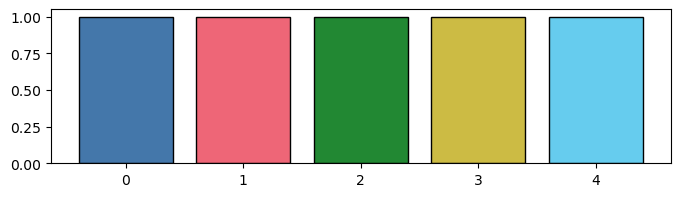

In [19]:
colors = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE']

plt.figure(figsize=(8,2))
for i, color in enumerate(colors):
    plt.bar(i, 1, color=color, edgecolor='black')

In [20]:
# Assign colors to each module
testchunk['color'] = testchunk['0.0'].apply(lambda x: colors[x-1])

testchunk

,type_pre,weight,0.0,out_to_ovis_weight,out_to_ovis_rank,color
0,SMP176,299,1,544,2,#4477AA
1,SMP566,203,1,242,0,#4477AA
2,SMP520,125,1,258,0,#4477AA
3,SMP383,281,1,543,1,#4477AA
4,SMP314,106,1,131,2,#4477AA
5,SMP237,163,1,337,0,#4477AA
6,SMP052,361,1,614,0,#4477AA
7,SMP051,157,1,273,0,#4477AA
8,VES047,118,2,118,0,#EE6677
9,SMP556,102,2,117,6,#EE6677


In [21]:
testchunk_edit = testchunk.sort_values(by='0.0', ascending=True, ignore_index=True)
# Testchunk drop columns
testchunk_small = testchunk_edit[['type_pre', 'out_to_ovis_rank', 'color']]
# Pivot so that celltypes in the index, and oviIN ranks in the columns and 0.0 is a second level column

testchunk_pivot = testchunk_small.pivot(index='out_to_ovis_rank', columns=['type_pre', 'color'], values='out_to_ovis_rank')

# Replace any non-Nan values with the number 1
testchunk_pivot = testchunk_pivot.notnull().astype('int')

# replace any zeros with NaN
testchunk_pivot = testchunk_pivot.replace(0, np.nan)

# Add in a blank row after 7 for plotting purposes
testchunk_pivot.loc[10]= np.nan

# Sort the index
testchunk_pivot = testchunk_pivot.sort_index(ascending=True)

testchunk_pivot

type_pre,SMP176,SMP566,SMP520,SMP383,SMP314,SMP237,SMP052,SMP051,LAL134,IB017,pC1e,CRE075,SMP544,SMP556,VES047,pC1d,SMP185,LAL022,SMP153,SMP007,SMP179,OA-VUMa7,CRE077,SMP386,FS1A,FC2C,FC2B,SMP112,SMP175,SMP042,SMP550,SMP551,SMP311
color,#4477AA,#4477AA,#4477AA,#4477AA,#4477AA,#4477AA,#4477AA,#4477AA,#EE6677,#EE6677,#EE6677,#EE6677,#EE6677,#EE6677,#EE6677,#EE6677,#228833,#228833,#228833,#228833,#228833,#228833,#228833,#228833,#228833,#228833,#228833,#228833,#66CCEE,#66CCEE,#66CCEE,#66CCEE,#66CCEE
out_to_ovis_rank,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN
1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


/var/folders/db/q8_kwk2x73df8d997nrf14k1nfx1_b/T/ipykernel_47351/3922035041.py:28: UserWarning: The label '_' of <BarContainer object of 1 artists> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles[33:], labels_final[-5:], loc='upper right', fontsize=16)


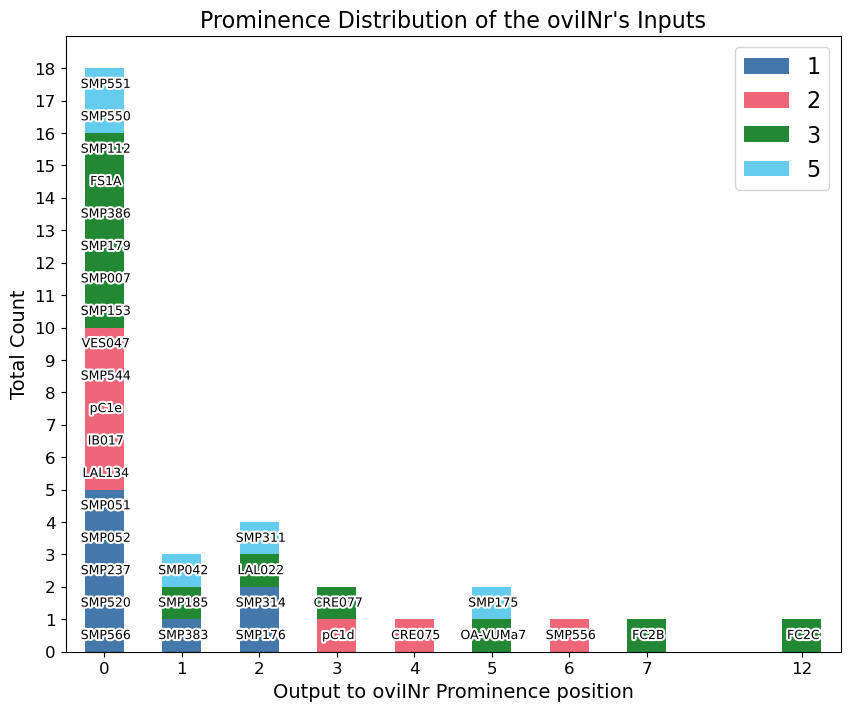

In [22]:
# Plotting the data
fig, ax = plt.subplots(figsize=(10, 8))
# stacked bar plot using 0.0 index as color group
testchunk_pivot.plot(kind='bar', stacked=True, ax=ax, color=testchunk_pivot.columns.get_level_values(1), label=None)


# generate labels for each stacked bar using the cell type names
labels_edit = testchunk_pivot.columns.get_level_values(0).to_list()

# annotate the stacked bar plot
for i in range(len(testchunk_pivot)):
    y = 0
    for j in range(len(testchunk_pivot.columns)):
        if testchunk_pivot.iloc[i,j] == 1:
            # annotate with black font and white outline
            ax.text(i+0.02, y + 0.5, labels_edit[j], ha='center', va='center', rotation=0, fontsize=9, color='black', path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
            y += 1

ax.legend().remove()

#make my own legend
for i, color in enumerate(colors):
    ax.bar(0, 0, color=color, label=labels_edit[i])

labels_final = labels_edit + [1,2,3, "_",5]
# I only want to display the last five legend items
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[33:], labels_final[-5:], loc='upper right', fontsize=16)

plt.xticks(rotation=0,fontsize=12)
ax.set_yticks(np.linspace(0, 18, 19))
ax.set_yticklabels(np.linspace(0, 18, 19, dtype=int), fontsize=12)
ax.set_ylabel('Total Count', fontsize=14)
ax.set_xlabel('Output to oviINr Prominence position', fontsize=14)
ax.set_title("Prominence Distribution of the oviINr's Inputs", fontsize=16)
plt.ylim(0, 19)
xticks = ax.xaxis.get_major_ticks()
xticks[8].set_visible(False)



(0.0, 20.0)

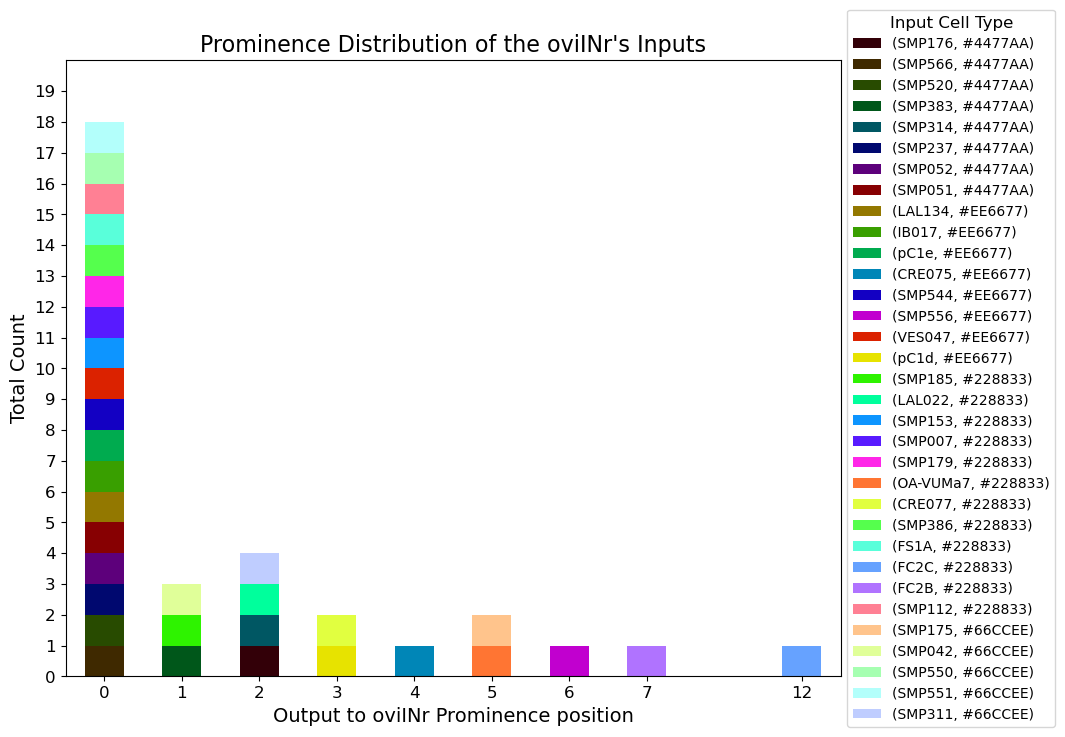

In [23]:
fig, ax = plt.subplots(figsize=(10, 8))
# stacked bar plot
testchunk_pivot.plot(kind='bar', stacked=True, ax=ax, color= generate_colormap(len(testchunk_pivot.columns)))

# generate labels for each stacked bar using the cell type names
labels = testchunk_pivot.columns
# legend on the right of plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Input Cell Type', title_fontsize='large', fontsize='medium')
plt.xticks(rotation=0,fontsize=12)
# yticks should be 19 of them evenly spaced
ax.set_yticks(np.linspace(0, 19, 20))
ax.set_yticklabels(np.linspace(0, 19, 20, dtype=int), fontsize=12)
ax.set_ylabel('Total Count', fontsize=14)
ax.set_xlabel('Output to oviINr Prominence position', fontsize=14)
ax.set_title("Prominence Distribution of the oviINr's Inputs", fontsize=16)
xticks = ax.xaxis.get_major_ticks()
xticks[8].set_visible(False)
plt.ylim(0, 20)


# Input R Connectivity Circle Graph (Figure 3B)

In [24]:
# Create the upstream rings figure for figure 3B
# find ovi_inputs_new has any None
ovi_inputs_new[ovi_inputs_new.isnull().any(axis=1)] # results in empty dataframe

,type_pre,weight


In [25]:
# Need to only display the label of known celltypes labels which means any generic name labels
# Such as CRE, SMP, SIP, SLP labels should be marked as empyt string
for i in range(len(ovi_inputs_new)):
    celltype = ovi_inputs_new['type_pre'][i][:3]
    if celltype in ['CRE', 'SMP', 'SIP', 'SLP', 'LAL', 'AOT', 'PLP', 'WED', 'AVL', 'ATL', 'Tu', 'AVL', 'VES', 'SAD']:
        ovi_inputs_new['type_pre'][i] = ''
    elif ovi_inputs_new['type_pre'][i][:2] in [ 'LT', 'CL', 'IB', 'PL', 'PS', 'PV', 'AM']:
        ovi_inputs_new['type_pre'][i] = ''
    else:
        continue
ovi_inputs_new



/var/folders/db/q8_kwk2x73df8d997nrf14k1nfx1_b/T/ipykernel_95551/4091094339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ovi_inputs_new['type_pre'][i] = ''
/var/folders/db/q8_kwk2x73df8d997nrf14k1nfx1_b/T/ipykernel_95551/4091094339.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ovi_inputs_new['type_pre'][i] = ''


,type_pre,weight
0,FS1A,892
1,,370
2,,361
3,,299
4,FC2B,290
...,...,...
963,,1
964,,1
965,,1
966,,1


In [26]:
# Check list for known celltypes
ovi_inputs_new['type_pre'].unique()

array(['FS1A', '', 'FC2B', 'FC2C', 'pC1e', 'pC1d', 'OA-VUMa7', 'FS1B',
       'PPL102', 'PAL02', 'FS3', 'LHPV10a1', 'OA-VUMa6', 'OA-VPM3',
       'MBON31', 'LHPD5d1', 'pC1a', 'LHPD2c5', 'NPFL1-I', 'aIPg2',
       'PPL108', 'FB5G', 'PPL107', 'LHPV5e3', 'aIPg1', 'LHPV10b1', 'FC2A',
       'LC33a', 'LHPD2c1', 'FB4P_a', 'pC1b', 'FC1C', 'LHPD2c6', 'LPN',
       'aIPg4', 'LHAD1b2_a', 'MBON04', 'LHAD1b6_a', 'FB5Q', 'FB5D',
       'FB5O', 'pC1c', 'FB5E', 'FB5K', 'DNp27', 'aIPg3', 'PAL03', 'FB5V',
       'M_spPN4t9', 'MBON12', 'mALD1', 'FB5F', 'FB1H', 'LHPV8a1',
       'LHPD2a6', 'MBON01', 'M_spPN5t10', 'LHPV5g1_a', 'FB3E', 'FB5AA',
       'DNa03', 'mALB2', 'FB6W', 'LHPV3a1', 'LHPD2c7', 'MBON32', 'LNd',
       'MBON35', 'LC33b', 'FB5C', 'LHPD5a1', 'PPM1205', 'LHPD2a7', 'FB6X',
       'FB4F_a', 'MBON33', 'v2LN37', 'vpoEN', 'LHPD2a2', 'LHPD2a1',
       'LHAD1b1_b', 'PFL3', 'FB7E', 'FB6U', 'LHAD1b2_c', 'LHPD2c2',
       'PAM13', 'PAM01_b', 'FB5L', 'LHPD2c3', 'FC1E', 'FS4C', 'PAL01',
       'OA-VUM

Text(0.5, 0.98, 'Cell Type Breakdown')

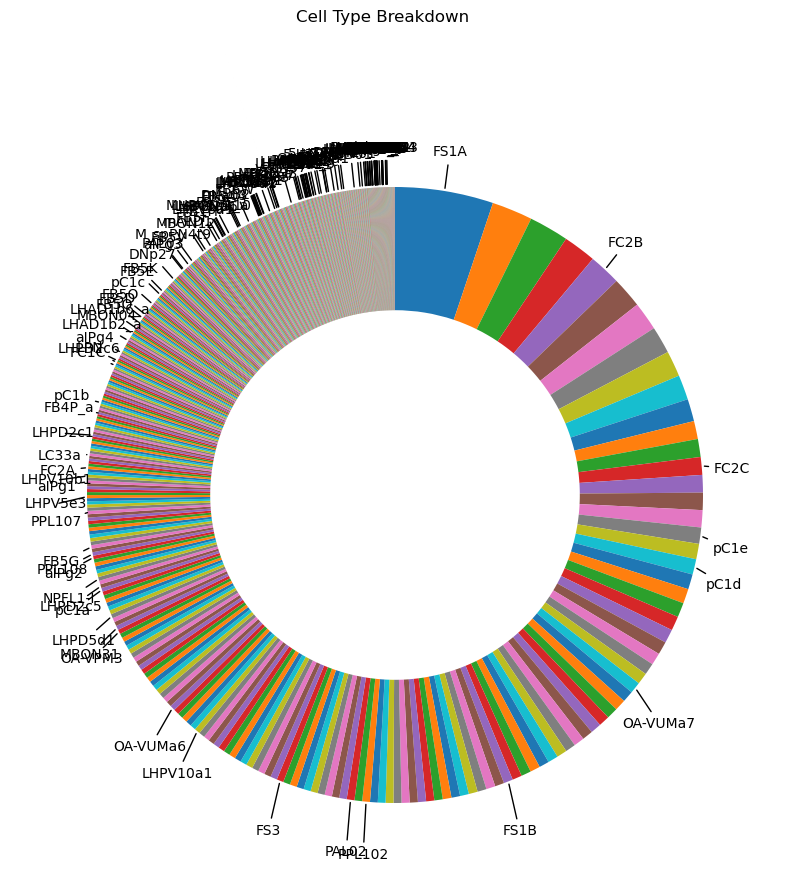

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the concentric ring but i want to only label the top 10
wedges, labels = ax.pie(ovi_inputs_new['weight'], startangle=90, counterclock=False, wedgeprops=dict(width=0.4))
# label only the top 10 wedges with simple text and a small line from the wedge to the label
for i in range(900):
    if ovi_inputs_new['type_pre'][i] == '':
        continue
    ang = (wedges[i].theta2 + wedges[i].theta1) / 2
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    ax.annotate(ovi_inputs_new['type_pre'][i], xy=(x, y), xytext=(1.1*x, 1.15*y),
                fontsize=10, ha='center', va='top', color='black',
                arrowprops=dict(arrowstyle='-', color='black', lw=1))

fig.suptitle("Cell Type Breakdown")


# Input R Region Breakdown Graph

In [6]:
# Region Breakdown
mod

,id,key,0.0,0.05,0.1,0.5,0.75,1.0,instance,celltype,...,status,cropped,statusLabel,cellBodyFiber,somaRadius,somaLocation,roiInfo,notes,inputRois,outputRois
0,1003215282,1,1,1,1,1,1,1,CL229_R,CL229,...,Traced,False,Roughly traced,PDM19,301.0,"[23044, 14981, 11600]","{'INP': {'pre': 87, 'post': 351, 'downstream':...",NaN,"['EPA(R)', 'GOR(R)', 'IB', 'ICL(R)', 'INP', 'S...","['GOR(R)', 'IB', 'ICL(R)', 'INP', 'SCL(R)', 'S..."
1,1005952640,2,2,1,1,2,2,2,IB058_R,IB058,...,Traced,False,Roughly traced,PVL20,NaN,NaN,"{'INP': {'pre': 464, 'post': 1327, 'downstream...",NaN,"['ATL(R)', 'IB', 'ICL(R)', 'INP', 'PLP(R)', 'S...","['ATL(R)', 'IB', 'ICL(R)', 'INP', 'PLP(R)', 'S..."
2,1006928515,3,1,1,1,3,3,3,CL300_R,CL300,...,Traced,False,Roughly traced,PVL13,236.0,"[12083, 10523, 16816]","{'INP': {'pre': 79, 'post': 126, 'downstream':...",NaN,"['ATL(R)', 'IB', 'ICL(R)', 'INP', 'SCL(R)', 'S...","['ATL(R)', 'IB', 'ICL(R)', 'INP', 'SCL(R)', 'S..."
3,1007260806,4,2,1,1,4,4,4,CL301_R,CL301,...,Traced,False,Roughly traced,PVL13,236.0,"[13524, 10108, 16480]","{'INP': {'pre': 40, 'post': 128, 'downstream':...",NaN,"['GOR(R)', 'IB', 'ICL(R)', 'INP', 'PLP(R)', 'S...","['IB', 'ICL(R)', 'INP', 'PLP(R)', 'SCL(R)', 'S..."
4,1008024276,5,3,2,2,5,5,5,FB5N_R,FB5N,...,Traced,False,Roughly traced,AVM08,472.5,"[19178, 29711, 37312]","{'SNP(L)': {'post': 5, 'upstream': 5, 'mito': ...",SMPCREFB5_4,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506,987273073,2507,3,8,8,409,604,629,(PVL05)_L,NaN,...,Traced,False,Roughly traced,NaN,NaN,NaN,"{'SNP(R)': {'pre': 65, 'post': 52, 'downstream...",NaN,"['CRE(-ROB,-RUB)(R)', 'CRE(-RUB)(L)', 'CRE(L)'...","['CRE(-ROB,-RUB)(R)', 'CRE(-RUB)(L)', 'CRE(L)'..."
2507,987842109,2508,3,9,23,533,780,815,NaN,NaN,...,Orphan,NaN,Orphan hotknife,NaN,NaN,NaN,"{'SNP(R)': {'pre': 2, 'post': 13, 'downstream'...",NaN,"['SMP(R)', 'SNP(R)']","['SMP(R)', 'SNP(R)']"
2508,988567837,2509,2,3,4,16,58,63,FB4G_R,FB4G,...,Traced,False,Roughly traced,AVM08,NaN,NaN,"{'SNP(R)': {'pre': 6, 'post': 73, 'downstream'...",CRELALFB4_3,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F..."
2509,988909130,2510,2,3,4,389,559,572,FB5V_R,FB5V,...,Traced,False,Roughly traced,AVM10,296.5,"[13226, 32024, 18600]","{'SNP(R)': {'pre': 1, 'post': 28, 'downstream'...",CRELALFB5,"['AB(R)', 'CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX',...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F..."


In [7]:
# Import roi data
roi_df = pd.read_excel('all_roi_df.xlsx')
roi_super = roi_df['Super'].dropna()
roi_supersplit = roi_df['Super_split'].dropna()
roi_df

,Super,Super_split,L1,L2,L3,L4,Color,Color2
0,AL,AL(L),AL(L),NaN,NaN,NaN,cadetblue,NaN
1,AL,NaN,NaN,AL-D(L),NaN,NaN,NaN,cadetblue
2,AL,NaN,NaN,AL-DA2(L),NaN,NaN,NaN,cadetblue
3,AL,NaN,NaN,AL-DA3(L),NaN,NaN,NaN,cadetblue
4,AL,NaN,NaN,AL-DA4m(L),NaN,NaN,NaN,cadetblue
...,...,...,...,...,...,...,...,...
225,VMNP,NaN,NaN,VES(L),NaN,NaN,NaN,firebrick
226,VMNP,NaN,NaN,VES(R),NaN,NaN,NaN,firebrick
227,AL,AL(L),mALT(L),mALT(L),NaN,NaN,cadetblue,NaN
228,AL,AL(R),mALT(R),mALT(R),NaN,NaN,cadetblue,NaN


In [8]:
# reads all bodyIds in connectome (fetch_synaptic_connections)
ids = mod['id']
roi_info = fetch_synapse_connections(NC(bodyId=ids), NC(bodyId=423101189), batch_size=1000)
roi_info

  0%|          | 0/21608 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

,bodyId_pre,bodyId_post,roi_pre,roi_post,x_pre,y_pre,z_pre,x_post,y_post,z_post,confidence_pre,confidence_post
0,699363923,423101189,SMP(R),SMP(R),18710,34066,11978,18714,34056,11998,0.836,0.462087
1,699363923,423101189,SMP(R),SMP(R),22445,25222,10972,22414,25228,10973,0.994,0.456265
2,699363923,423101189,SMP(R),SMP(R),22609,32249,11168,22598,32226,11165,0.996,0.895489
3,699358695,423101189,SMP(R),SMP(R),23605,19671,12076,23607,19654,12075,0.811,0.844000
4,699358695,423101189,SMP(R),SMP(R),21837,24629,12812,21852,24648,12828,0.941,0.844886
...,...,...,...,...,...,...,...,...,...,...,...,...
21603,1875284107,423101189,VES(R),VES(R),22272,23848,29541,22261,23861,29557,0.933,0.854542
21604,1844249219,423101189,IB,IB,25286,16199,21709,25311,16190,21743,0.752,0.604000
21605,1844249219,423101189,VES(R),VES(R),22038,21037,28943,22057,21047,28964,0.937,0.425953
21606,1848000962,423101189,VES(R),VES(R),23349,21550,26101,23335,21569,26106,0.817,0.993132


In [9]:
# Drop all unnecessary columns
roi_info_small = roi_info[['bodyId_pre', 'roi_pre', 'bodyId_post', 'roi_post']]
# Collapse on roi_post and count the number of synapses in a new column called weight
roi_info_grouped = roi_info_small.groupby(['roi_post', 'bodyId_pre']).size().reset_index(name='weight')

# rename roi_post to roi
roi_info_grouped = roi_info_grouped.rename(columns = {'roi_post':'roi', 'bodyId_pre':'bodyId'})

# mergo onto modularity data
inputs_roi = pd.merge(mod, roi_info_grouped, left_on='id', right_on='bodyId', how='inner')

In [10]:
inputs_roi

,id,key,0.0,0.05,0.1,0.5,0.75,1.0,instance,celltype,...,cellBodyFiber,somaRadius,somaLocation,roiInfo,notes,inputRois,outputRois,roi,bodyId,weight
0,1003215282,1,1,1,1,1,1,1,CL229_R,CL229,...,PDM19,301.0,"[23044, 14981, 11600]","{'INP': {'pre': 87, 'post': 351, 'downstream':...",NaN,"['EPA(R)', 'GOR(R)', 'IB', 'ICL(R)', 'INP', 'S...","['GOR(R)', 'IB', 'ICL(R)', 'INP', 'SCL(R)', 'S...",IB,1003215282,1
1,1005952640,2,2,1,1,2,2,2,IB058_R,IB058,...,PVL20,NaN,NaN,"{'INP': {'pre': 464, 'post': 1327, 'downstream...",NaN,"['ATL(R)', 'IB', 'ICL(R)', 'INP', 'PLP(R)', 'S...","['ATL(R)', 'IB', 'ICL(R)', 'INP', 'PLP(R)', 'S...",IB,1005952640,3
2,1006928515,3,1,1,1,3,3,3,CL300_R,CL300,...,PVL13,236.0,"[12083, 10523, 16816]","{'INP': {'pre': 79, 'post': 126, 'downstream':...",NaN,"['ATL(R)', 'IB', 'ICL(R)', 'INP', 'SCL(R)', 'S...","['ATL(R)', 'IB', 'ICL(R)', 'INP', 'SCL(R)', 'S...",IB,1006928515,1
3,1007260806,4,2,1,1,4,4,4,CL301_R,CL301,...,PVL13,236.0,"[13524, 10108, 16480]","{'INP': {'pre': 40, 'post': 128, 'downstream':...",NaN,"['GOR(R)', 'IB', 'ICL(R)', 'INP', 'PLP(R)', 'S...","['IB', 'ICL(R)', 'INP', 'PLP(R)', 'SCL(R)', 'S...",SPS(R),1007260806,7
4,1008024276,5,3,2,2,5,5,5,FB5N_R,FB5N,...,AVM08,472.5,"[19178, 29711, 37312]","{'SNP(L)': {'post': 5, 'upstream': 5, 'mito': ...",SMPCREFB5_4,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...",CRE(R),1008024276,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3496,987273073,2507,3,8,8,409,604,629,(PVL05)_L,NaN,...,NaN,NaN,NaN,"{'SNP(R)': {'pre': 65, 'post': 52, 'downstream...",NaN,"['CRE(-ROB,-RUB)(R)', 'CRE(-RUB)(L)', 'CRE(L)'...","['CRE(-ROB,-RUB)(R)', 'CRE(-RUB)(L)', 'CRE(L)'...",CRE(R),987273073,1
3497,987842109,2508,3,9,23,533,780,815,NaN,NaN,...,NaN,NaN,NaN,"{'SNP(R)': {'pre': 2, 'post': 13, 'downstream'...",NaN,"['SMP(R)', 'SNP(R)']","['SMP(R)', 'SNP(R)']",SMP(R),987842109,1
3498,988567837,2509,2,3,4,16,58,63,FB4G_R,FB4G,...,AVM08,NaN,NaN,"{'SNP(R)': {'pre': 6, 'post': 73, 'downstream'...",CRELALFB4_3,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...",LAL(R),988567837,1
3499,988909130,2510,2,3,4,389,559,572,FB5V_R,FB5V,...,AVM10,296.5,"[13226, 32024, 18600]","{'SNP(R)': {'pre': 1, 'post': 28, 'downstream'...",CRELALFB5,"['AB(R)', 'CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX',...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...",CRE(R),988909130,1


In [11]:
# Filter dataframe to only include the columns needed
inputs_roi_filtered = inputs_roi[['roi','celltype', 'weight']]

# Check for 'None' celltype
#inputs_roi_filtered[inputs_roi_filtered['celltype']=='None']

# Drop the 'None' celltype
inputs_roi_filtered = inputs_roi_filtered[inputs_roi_filtered['celltype']!='None']

inputs_roi_filtered


,roi,celltype,weight
0,IB,CL229,1
1,IB,IB058,3
2,IB,CL300,1
3,SPS(R),CL301,7
4,CRE(R),FB5N,1
...,...,...,...
3496,CRE(R),NaN,1
3497,SMP(R),NaN,1
3498,LAL(R),FB4G,1
3499,CRE(R),FB5V,1


In [12]:
# group by roi so that the celltypes are in each roi grou that they belong in and sum downstream values
inputs_roi_grouped = inputs_roi_filtered.groupby(['roi', 'celltype'], as_index=False).sum()
inputs_roi_grouped


,roi,celltype,weight
0,ATL(R),AOTU024,1
1,ATL(R),IB109,1
2,ATL(R),LC46a,2
3,ATL(R),SMP018_b,3
4,ATL(R),SMP327,3
...,...,...,...
1644,VES(R),oviDNa,1
1645,VES(R),pC1d,21
1646,VES(R),v2LN37,3
1647,VES(R),vpoDN,1


In [13]:
# Filter out the unknown celltypes
for i in range(len(inputs_roi_grouped)):
    celltype = inputs_roi_grouped['celltype'][i][:3]
    if celltype in ['CRE', 'SMP', 'SIP', 'SLP', 'LAL', 'AOT', 'PLP', 'WED', 'AVL', 'ATL', 'AVL', 'VES', 'SAD']:
        inputs_roi_grouped['celltype'][i] = ''
    elif inputs_roi_grouped['celltype'][i][:2] in [ 'LT', 'CL', 'IB', 'PL', 'PS', 'PV']:
        inputs_roi_grouped['celltype'][i] = ''
    else:
        continue
inputs_roi_grouped

/var/folders/kn/8dwfcxtd2p3c4kzb8yj0j5pr0000gn/T/ipykernel_29737/3156857018.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputs_roi_grouped['celltype'][i] = ''
/var/folders/kn/8dwfcxtd2p3c4kzb8yj0j5pr0000gn/T/ipykernel_29737/3156857018.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputs_roi_grouped['celltype'][i] = ''
/var/folders/kn/8dwfcxtd2p3c4kzb8yj0j5pr0000gn/T/ipykernel_29737/3156857018.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

,roi,celltype,weight
0,ATL(R),,1
1,ATL(R),,1
2,ATL(R),LC46a,2
3,ATL(R),,3
4,ATL(R),,3
...,...,...,...
1644,VES(R),oviDNa,1
1645,VES(R),pC1d,21
1646,VES(R),v2LN37,3
1647,VES(R),vpoDN,1


In [14]:
#map roi to super roi
color_dict = mpl.colormaps['Purples'].resampled(7).reversed()
roi_super_dict = {'SMP(R)': 'SNP', 'SMP(L)': 'SNP', 'SIP(R)': 'SNP', 'SIP(L)': 'SNP', 'VES(R)': 'VMNP', 'LAL(R)': 'LX', 'IB': 'INP', 'CRE(R)': 'INP', 'CRE(L)': 'INP', 'ATL(R)': 'INP', 'ATL(L)': 'AL', 'VES(L)': 'VMNP', 'GOR(R)': 'VMNP', 'GOR(L)': 'VMNP', 'SPS(R)': 'VMNP', 'SPS(L)': 'VMNP', 'FLA(R)': 'PENP', 'FLA(L)': 'PENP', 'PENP': 'PENP', 'AL': 'AL', 'PENP': 'PENP', 'CAN(R)': 'PENP'}
inputs_roi_grouped['super_roi'] = inputs_roi_grouped['roi'].map(roi_super_dict)

inputs_roi_grouped

,roi,celltype,weight,super_roi
0,ATL(R),,1,INP
1,ATL(R),,1,INP
2,ATL(R),LC46a,2,INP
3,ATL(R),,3,INP
4,ATL(R),,3,INP
...,...,...,...,...
1644,VES(R),oviDNa,1,VMNP
1645,VES(R),pC1d,21,VMNP
1646,VES(R),v2LN37,3,VMNP
1647,VES(R),vpoDN,1,VMNP


In [15]:
color_dict = color_dict([0,1,2,3,4,5,6])
color_dict

array([[0.24705882, 0.        , 0.49019608, 1.        ],
       [0.35816993, 0.20784314, 0.5869281 , 1.        ],
       [0.47320261, 0.43267974, 0.69934641, 1.        ],
       [0.61960784, 0.60392157, 0.78431373, 1.        ],
       [0.77647059, 0.77908497, 0.88235294, 1.        ],
       [0.90980392, 0.90457516, 0.94771242, 1.        ],
       [0.98823529, 0.98431373, 0.99215686, 1.        ]])

In [16]:
# Check unique Roi 
inputs_roi_grouped['super_roi'].unique()

array(['INP', 'PENP', 'VMNP', 'LX', 'SNP'], dtype=object)

In [18]:
# inner layer sums the super_roi values into a total weight column
inner_layer = inputs_roi_grouped.groupby(['super_roi'], as_index=False).sum()

# drop roi and celltype columns
inner_layer = inner_layer.drop(columns=['roi', 'celltype'])

# map color to super_roi
inner_layer['color'] = 'darkturquoise'
inner_layer

,super_roi,weight,color
0,INP,3375,darkturquoise
1,LX,1425,darkturquoise
2,PENP,7,darkturquoise
3,SNP,11531,darkturquoise
4,VMNP,967,darkturquoise


In [20]:
# Outer layer only shows to groups for each super_roi, known and unknown celltypes
# this means each celltypes that has a name will be grouped together and all the blank celltypes will be grouped together
outer_layer = inputs_roi_grouped.copy()
for i in range(len(outer_layer)):
    if outer_layer['celltype'][i] == '':
        outer_layer['celltype'][i] = 'Unknown'
    else:
        outer_layer['celltype'][i] = 'Known'

# group by super_roi and celltype
outer_layer = outer_layer.groupby(['super_roi', 'celltype'], as_index=False).sum()

# Drop roi column
outer_layer = outer_layer.drop(columns=['roi'])
outer_layer

/var/folders/kn/8dwfcxtd2p3c4kzb8yj0j5pr0000gn/T/ipykernel_29737/1683018054.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_layer['celltype'][i] = 'Unknown'
/var/folders/kn/8dwfcxtd2p3c4kzb8yj0j5pr0000gn/T/ipykernel_29737/1683018054.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_layer['celltype'][i] = 'Unknown'
/var/folders/kn/8dwfcxtd2p3c4kzb8yj0j5pr0000gn/T/ipykernel_29737/1683018054.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

,super_roi,celltype,weight
0,INP,Known,724
1,INP,Unknown,2651
2,LX,Known,106
3,LX,Unknown,1319
4,PENP,Unknown,7
5,SNP,Known,2304
6,SNP,Unknown,9227
7,VMNP,Known,57
8,VMNP,Unknown,910


In [21]:
# map color to super_roi
outer_layer['color'] = 'orangered'
# change the color to "light"+ color for the unknown celltypes and 'dark'+ color for the known celltypes
for i in range(len(outer_layer)):
    if outer_layer['celltype'][i] == 'Unknown':
        outer_layer['color'][i] = 'darkorange'
outer_layer

/var/folders/kn/8dwfcxtd2p3c4kzb8yj0j5pr0000gn/T/ipykernel_29737/1722493927.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_layer['color'][i] = 'darkorange'
/var/folders/kn/8dwfcxtd2p3c4kzb8yj0j5pr0000gn/T/ipykernel_29737/1722493927.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_layer['color'][i] = 'darkorange'
/var/folders/kn/8dwfcxtd2p3c4kzb8yj0j5pr0000gn/T/ipykernel_29737/1722493927.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

,super_roi,celltype,weight,color
0,INP,Known,724,orangered
1,INP,Unknown,2651,darkorange
2,LX,Known,106,orangered
3,LX,Unknown,1319,darkorange
4,PENP,Unknown,7,darkorange
5,SNP,Known,2304,orangered
6,SNP,Unknown,9227,darkorange
7,VMNP,Known,57,orangered
8,VMNP,Unknown,910,darkorange


In [22]:
# Filter out the roi that have less than 100 synapses
inner_layer = inner_layer[inner_layer['weight'] >= 10]
outer_layer = outer_layer[outer_layer['weight'] >= 10]


Text(0.5, 0.98, 'Cell Type Breakdown by ROI')

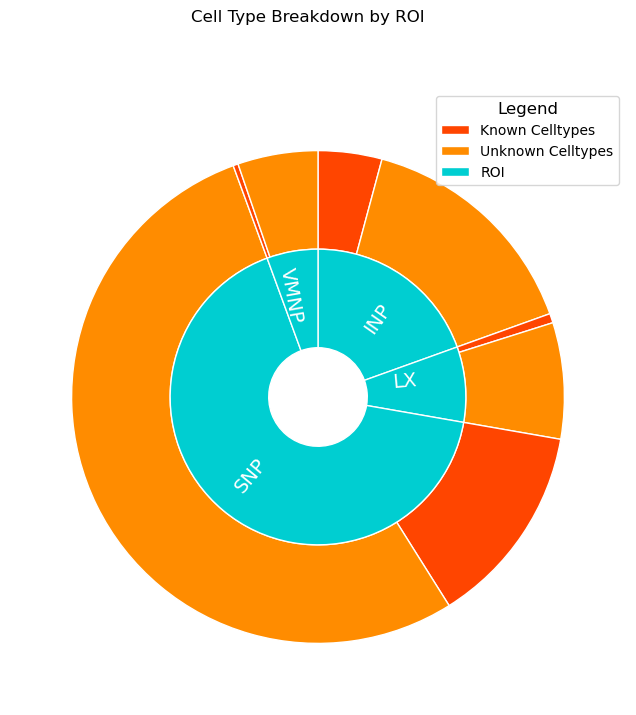

In [23]:
# create a double layered pie plot with the roi as the inner layer and the celltypes as the outer layer
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the outer layer of the pie plot
wedges1, _ = ax.pie(outer_layer['weight'],  colors=outer_layer['color'],radius=1, rotatelabels=True,  startangle=90, counterclock=False, wedgeprops=dict(width=0.4, edgecolor='white'))

# Plot the inner layer of the pie plot
wedges2, _ = ax.pie(inner_layer['weight'], labels=inner_layer['super_roi'], colors= inner_layer['color'],labeldistance=0.5, rotatelabels= True, radius=1-0.4, startangle=90, counterclock=False, wedgeprops=dict(width=0.4, edgecolor='white'), textprops={'fontsize': 14, 'color': 'white'})
    
# legend with orangered, darkorange, darkturquoise corresponding to known celltypes, unknown celltypes, and roi respectively
legend_elements = [mpl.patches.Patch(facecolor='orangered', edgecolor='white', label='Known Celltypes'), mpl.patches.Patch(facecolor='darkorange', edgecolor='white', label='Unknown Celltypes'), mpl.patches.Patch(facecolor='darkturquoise', edgecolor='white', label='ROI')]
ax.legend(handles=legend_elements, loc='upper right', title='Legend', title_fontsize='large', fontsize='medium')

fig.suptitle("Cell Type Breakdown by ROI")

In [24]:
fig.savefig('Figures-oviIN/celltype_breakdown.svg', format='svg', dpi=1200)


### Notes
I notice that these are not sorted and it think it would be visually helpful to see that..  might alight with the known types